# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import transformers
from torch import nn
import torch
from multihead_models import *

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Distil GPT2

In [2]:
dgpt2 = transformers.AutoModelForCausalLM.from_pretrained('distilgpt2')
dgpt2

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
dgpt2copy = MOEModelForCausalLM(dgpt2)
dgpt2copy

MOEModelForCausalLM(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MOEMLP(
          (mlps): ModuleList(
            (0-2): 3 x GPT2MLP(
              (c_fc): Conv1D()
              (c_proj): Conv1D()
              (act): NewGELUActivation()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
from transformers import AutoTokenizer 
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
instring = 'hello'

toks = tokenizer(instring, return_tensors='pt')
outs = dgpt2.forward(**toks)
outsmoe = dgpt2copy.forward(**toks)
assert outs.logits.equal(outsmoe[0])
assert dgpt2copy.generate(**toks).equal(dgpt2.generate(**toks))

## Llama

In [8]:
llama = transformers.AutoModelForCausalLM.from_pretrained('/zoo/llama2/llama2-7b-hf', torch_dtype=torch.bfloat16)
llama

Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameteriza

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [9]:
llamacopy = MOEModelForCausalLM.from_other(llama)
llamacopy

deep copied model
added MOE MLPs


MOEModelForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): MOEMLP(
          (mlps): ModuleList(
            (0): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLU()
            )
          )
        )
        (input_layernorm): LlamaRMS

In [19]:
from transformers import AutoTokenizer 
tokenizerllama = AutoTokenizer.from_pretrained("/zoo/llama2/llama2-7b-hf")
llama.cpu(), llamacopy.cpu()

instring = 'hello'
toks = tokenizerllama(instring, return_tensors='pt')
outs = llama.forward(**toks)
outsmoe = llamacopy.forward(**toks)
assert outs.logits.equal(outsmoe[0])
print('first assert passed')

outs = llama.cuda().generate(input_ids=toks['input_ids'].cuda(), attention_mask=toks['attention_mask'].cuda())
print('llama generation complete')
outsmoe = llamacopy.cuda().generate(input_ids=toks['input_ids'].cuda(), attention_mask=toks['attention_mask'].cuda())
print('llamacopy generation complete')
assert outsmoe.equal(outs)
print('second assert passed')

first assert passed


/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


llama generation complete
llamacopy generation complete
second assert passed


# Training

In [2]:
# Data stuff
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AdamW, get_scheduler

# Load the dataset
file_path = '/hdd3/sonia/data/adult.csv'  # Update this with the correct path
data = pd.read_csv(file_path)

# Preprocess the data: Convert each row to a string
def row_to_string(row):
    return ", ".join([f"{col} is {val}" for col, val in row.items()]) + "."
def row_to_sentences(row):
    return '. '.join([str(col).strip() + " is " + str(val).strip() for col, val in zip(row.index, row.values)])
def row_to_col_sentences(row):
    return [str(col).strip() + " is " + str(val).strip() for col, val in zip(row.index, row.values)]

text_data = data.apply(row_to_col_sentences, axis=1).tolist()
text_data

# class TextDataset(Dataset):
#     def __init__(self, texts, tokenizer, max_length=512):
#         self.texts = texts
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         tokenized_text = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors="pt")
#         return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze()

[['age is 39',
  'workclass is State-gov',
  'fnlwgt is 77516',
  'education is Bachelors',
  'education-num is 13',
  'marital-status is Never-married',
  'occupation is Adm-clerical',
  'relationship is Not-in-family',
  'race is White',
  'sex is Male',
  'capital-gain is 2174',
  'capital-loss is 0',
  'hours-per-week is 40',
  'native-country is United-States',
  'income is <=50K'],
 ['age is 50',
  'workclass is Self-emp-not-inc',
  'fnlwgt is 83311',
  'education is Bachelors',
  'education-num is 13',
  'marital-status is Married-civ-spouse',
  'occupation is Exec-managerial',
  'relationship is Husband',
  'race is White',
  'sex is Male',
  'capital-gain is 0',
  'capital-loss is 0',
  'hours-per-week is 13',
  'native-country is United-States',
  'income is <=50K'],
 ['age is 38',
  'workclass is Private',
  'fnlwgt is 215646',
  'education is HS-grad',
  'education-num is 9',
  'marital-status is Divorced',
  'occupation is Handlers-cleaners',
  'relationship is Not-in-fami

## Data

In [8]:
model = dgpt2copy # don't forget to change tokenizer name too

model.train()
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
dataset = TextDataset(text_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
from tqdm import tqdm 

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(dgpt2.parameters(), lr=5e-5)
num_training_steps = len(dataloader) * 3  # Number of epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

losses = []

for epoch in range(3):  # Train for 3 epochs
    for batch in tqdm(dataloader):
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = dgpt2(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # print(f"Epoch: {epoch}, Loss: {loss.item()}")
        losses.append(loss.item())

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1527 [00:00<?, ?it/s]

100%|██████████| 1527/1527 [18:24<00:00,  1.38it/s]


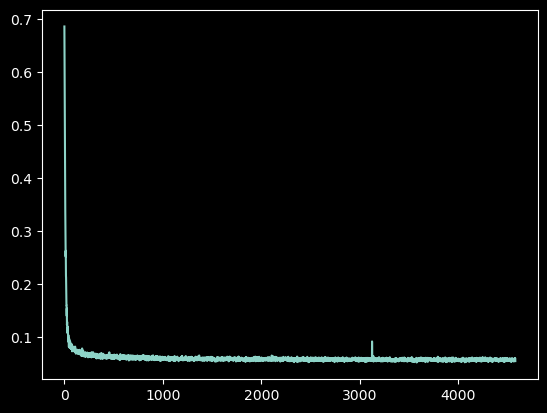

In [11]:
from matplotlib import pyplot as plt
plt.plot(losses)